# **Разработка системы рекомендаций для стримингового сервиса**

## Цель работы 
Состоит в разработке эффективной системы персонализированных рекомендаций для стримингового сервиса, с целью увеличения вовлеченности пользователей и времени, проводимого на платформе.

## Задачи
1. Провести анализ предоставленных данных о пользователях и их взаимодействии с контентом
2. Разработать и обучить несколько моделей рекомендаций (коллаборативная фильтрация, контентная фильтрация, гибридные подходы)
3. Разработать метрики для оценки качества рекомендаций
4. Реализовать механизм решения проблемы "холодного старта" для новых пользователей


## Датасеты
1. **Last.fm HetRec 2011** от GroupLens

Общее описание: Данные о пользователях, их прослушиваниях, тегах и социальных связях из музыкального сервиса Last.fm.

Файлы:
- `artists.dat`  
Структура: id | name | url | pictureURL  
Описание: Список артистов с их идентификаторами, названиями, ссылками на Last.fm и URL обложек.  

- `tags.dat`    
Структура: tagID | tagValue   
Описание: Словарь тегов (например, "metal", "rock"), которые пользователи присваивают артистам.

- `user_artists.dat`   
Структура: userID | artistID | weight  
Описание: Количество прослушиваний артистов пользователями. Чем выше weight, тем чаще пользователь слушал артиста.

- `user_taggedartists.dat`  
Структура: userID | artistID | tagID | day | month | year  
Описание: Разметка артистов тегами от пользователей с указанием даты.

- `user_taggedartists-timestamps.dat`   
Структура: userID | artistID | tagID | timestamp   
Описание: Аналогично предыдущему, но с Unix-временем вместо даты.

- `user_friends.dat`  
Структура: userID | friendID  
Описание: Социальные связи между пользователями (кто с кем "дружит").

2. **MovieLens 25M Dataset**

Общее описание:
Данные о фильмах, оценках пользователей, тегах и связях с внешними базами (IMDb, TMDb).

Файлы:

- `movies.csv`  
Структура: movieId | title | genres  
Описание: Список фильмов с их названиями (включая год выпуска) и жанрами (разделены "|").

- `ratings.csv`  
Структура: userId | movieId | rating | timestamp  
Описание: Оценки пользователей по шкале от 0.5 до 5.0 с временными метками.

- `tags.csv`  
Структура: userId | movieId | tag | timestamp  
Описание: Произвольные теги, которые пользователи присваивают фильмам (например, "classic", "sci-fi").

- `genome-scores.csv`  
Структура: movieId | tagId | relevance  
Описание: Релевантность тегов из genome-tags для каждого фильма (вес от 0 до 1).

- `genome-tags.csv`  
Структура: tagId | tag    
Описание: Описание тегов из genome-scores (например, "sci-fi", "action").

- `links.csv`  
Структура: movieId | imdbId | tmdbId  
Описание: Связи с идентификаторами IMDb и TMDb для каждого фильма.

**Загрузка зависимостей**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, save_npz, load_npz
import os
from time import time
from joblib import Parallel, delayed

# Анализ предоставленных данных о пользователях и их взаимодействии с контентом

## **Last.fm Dataset**

**Загрузка данных**

In [2]:
artists = pd.read_csv('artists.dat', sep='\t')
user_artists = pd.read_csv('user_artists.dat', sep='\t')
tags = pd.read_csv('tags.dat', sep='\t', encoding='ISO-8859-1')
user_tags = pd.read_csv('user_taggedartists.dat', sep='\t')
user_friends = pd.read_csv('user_friends.dat', sep='\t')

**Основные статистики**

In [3]:
# Артисты:
print("Количество артистов:", artists['id'].nunique())
print("Пример данных:\n")
display(artists.head(3))

Количество артистов: 17632
Пример данных:



,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...


In [4]:
# Прослушивания:
print("Количество уникальных артистов:", user_artists['userID'].nunique())
user_listens = user_artists.groupby('userID')['weight'].sum()
print(f"Среднее количество прослушиваний на одного пользователя: {user_listens.mean():.2f}")
print(f"Медиана прослушиваний: {user_listens.median():.0f}")
print("Мода прослушиваний:", user_listens.mode().iloc[0])

Количество уникальных артистов: 1892
Среднее количество прослушиваний на одного пользователя: 36566.58
Медиана прослушиваний: 21573
Мода прослушиваний: 4


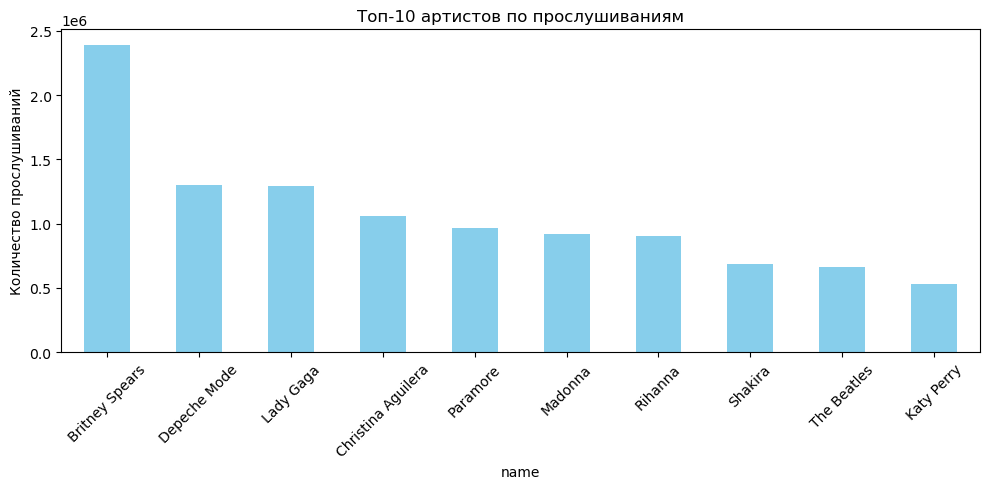

In [5]:
# Топ-10 артистов по прослушиваниям
top_artists = (
    user_artists.groupby('artistID')['weight']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

# Выводить артистов будем по их именам, а не просто по айди
top_artists = top_artists.merge(artists[['id', 'name']], left_on='artistID', right_on='id')

top_artists.set_index('name')['weight'].plot(
    kind='bar',
    title='Топ-10 артистов по прослушиваниям',
    figsize=(10, 5),
    color='skyblue',
    legend=False,
)

plt.ylabel('Количество прослушиваний')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

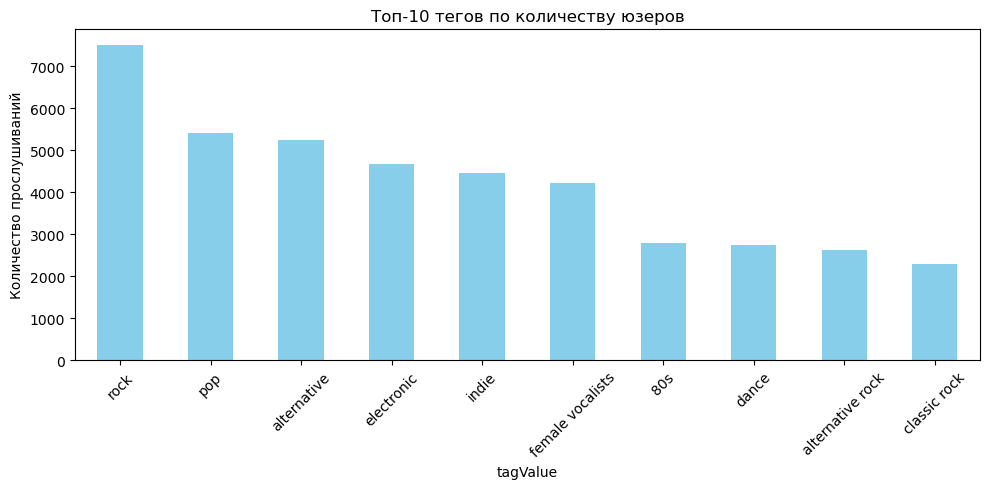

In [6]:
# Топ-10 тегов по количеству юзеров
top_tags = (
    user_tags.groupby('tagID')['userID']
    .count()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

top_tags = top_tags.merge(tags[['tagID', 'tagValue']], on='tagID')

top_tags.set_index('tagValue')['userID'].plot(
    kind='bar',
    title='Топ-10 тегов по количеству юзеров',
    figsize=(10, 5),
    color='skyblue',
    legend=False,
)

plt.ylabel('Количество прослушиваний')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

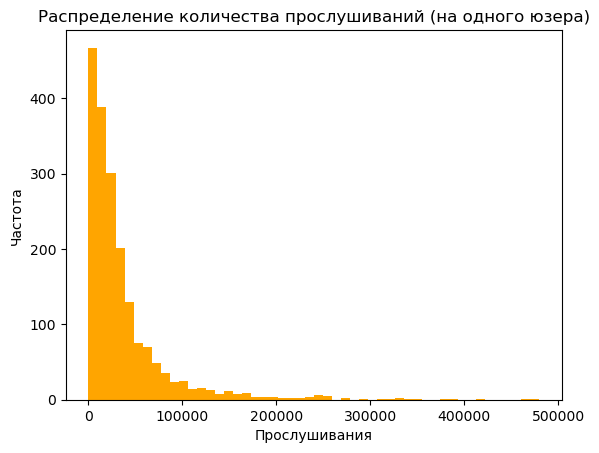

In [7]:
plt.hist(user_listens, bins=50, log=False, color='orange')
plt.title('Распределение количества прослушиваний (на одного юзера)')
plt.xlabel('Прослушивания')
plt.ylabel('Частота')
plt.show()

In [8]:
# Посмотрим сколько уникальных артистов слушают юзеры
user_artists.groupby('userID')['artistID'].nunique().value_counts()

artistID
50    1829
1        8
4        5
10       3
43       3
14       3
15       2
49       2
12       2
33       2
34       2
11       2
38       2
44       2
37       2
48       2
41       2
32       2
2        1
7        1
46       1
35       1
18       1
30       1
5        1
25       1
28       1
3        1
21       1
9        1
27       1
13       1
22       1
36       1
40       1
Name: count, dtype: int64

**Основные моменты:**  
1. Масштаб данных:  
* 18,632 артиста и 1,892 пользователя  
* Среднее число прослушиваний на пользователя: 36,566 (сильный перекос в сторону активных слушателей)
* Факт, что почти все слушатели одновременно слушают ровно по 50 разных артистов может быть связан с особенностью отбора данных командой GroupLens для конференции HetRec 2011. 

2. Распределение прослушиваний:  
* График показывает правостороннее распределение — большинство пользователей слушают немного, но есть "супер-фанаты" с сотнями тысяч прослушиваний.  
* Топ-артисты: Lady Gaga, Britney Spears, The Beatles (поп- и рок-исполнители с мировой славой).  

3. Теги:  
* Популярные теги: `pop`, `rock` и их разновидности — явное преобладание мейнстрим-жанров. Пользователи в основном ориентируются на известные и легко узнаваемые музыкальные стили. 

## **MovieLens 25M Dataset**

**Загрузка данных**

In [9]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
genome_tags = pd.read_csv('genome-tags.csv')
genome_scores = pd.read_csv('genome-scores.csv')
tags = pd.read_csv('tags.csv')

**Основные статистики**

In [10]:
# Фильмы:
print("Количество фильмов:", movies['movieId'].nunique())
print("Пример жанров:\n", movies['genres'].str.split('|').explode().value_counts())

Количество фильмов: 62423
Пример жанров:
 genres
Drama                 25606
Comedy                16870
Thriller               8654
Romance                7719
Action                 7348
Horror                 5989
Documentary            5605
Crime                  5319
(no genres listed)     5062
Adventure              4145
Sci-Fi                 3595
Children               2935
Animation              2929
Mystery                2925
Fantasy                2731
War                    1874
Western                1399
Musical                1054
Film-Noir               353
IMAX                    195
Name: count, dtype: int64


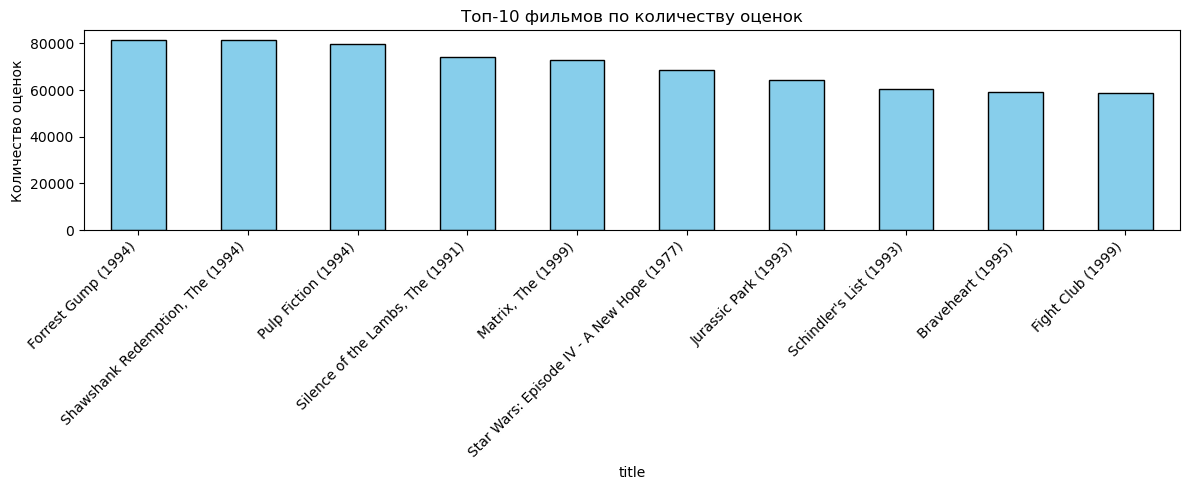

In [11]:
# Топ-10 фильмов по количеству оценок:
top_movies = (
    ratings['movieId'].value_counts()
    .head(10)
    .reset_index()
    .merge( 
        movies[['movieId', 'title']],
        left_on='movieId',
        right_on='movieId',
        how='left'
    )
    .set_index('title')
    ['count']
)

# Строим график
top_movies.plot(
    kind='bar',
    title='Топ-10 фильмов по количеству оценок',
    figsize=(12, 5),
    color='skyblue',
    edgecolor='black'
)
plt.ylabel('Количество оценок')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [12]:
# Оценки:
print("Количество пользователей", ratings['userId'].nunique())
print("Количество оценок:", len(ratings))
print(f"Средняя оценка: {ratings['rating'].mean():.2f}")
print("Медианная оценка:", ratings['rating'].median())
print("Мода оценок:", int(ratings['rating'].mode().iloc[0]))
print("\nРаспределение оценок:\n", ratings['rating'].value_counts().sort_index())

Количество пользователей 162541
Количество оценок: 25000095
Средняя оценка: 3.53
Медианная оценка: 3.5
Мода оценок: 4

Распределение оценок:
 rating
0.5     393068
1.0     776815
1.5     399490
2.0    1640868
2.5    1262797
3.0    4896928
3.5    3177318
4.0    6639798
4.5    2200539
5.0    3612474
Name: count, dtype: int64


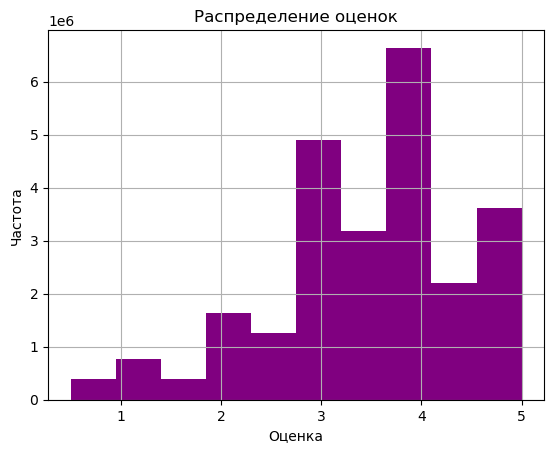

In [13]:
# Распределение оценок:
ratings['rating'].hist(bins=10, color='purple')
plt.title('Распределение оценок')
plt.xlabel('Оценка')
plt.ylabel('Частота')
plt.show()

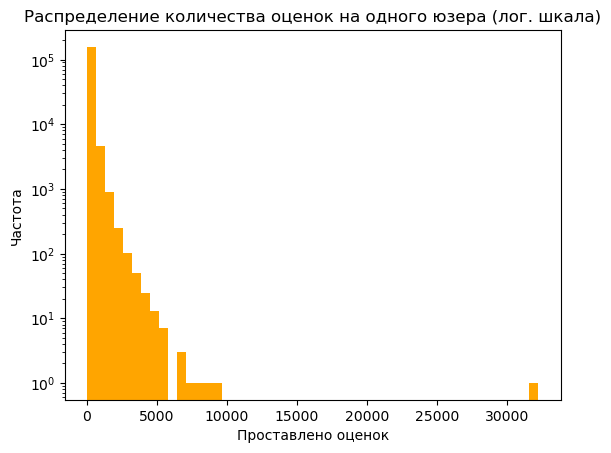

In [14]:
# Распределение колчиества оценок на одного пользователя
plt.hist(ratings.groupby('userId')['movieId'].count(), bins=50, log=True, color='orange')
plt.title('Распределение количества оценок на одного юзера (лог. шкала)')
plt.xlabel('Проставлено оценок')
plt.ylabel('Частота')
plt.show()

In [15]:
# Теги
print("Популярные пользовательские теги:\n", tags['tag'].value_counts().head(10))

Популярные пользовательские теги:
 tag
sci-fi                8330
atmospheric           6516
action                5907
comedy                5702
surreal               5326
based on a book       5079
twist ending          4820
funny                 4738
visually appealing    4526
dystopia              4257
Name: count, dtype: int64


**Основные моменты:**  
1. Масштаб данных:  
* 62,423 фильма и 25 млн оценок от (162 тыс.) пользователей.  
* Средний рейтинг: 3.53 (скошенное распределение с пиком на 4.0).  

2. Жанры:  
* Доминируют Drama (25.6 тыс.) и Comedy (16.9 тыс.).  
* Редкие жанры: Film-Noir (353), IMAX (195).  

3. Топ фильмов:  
* Лидеры по количеству оценок: *Forrest Gump*, *The Shawshank Redemption*, *Pulp Fiction* (классика 1990-х).  

4. Пользовательские теги:  
* Чаще всего отмечают: `sci-fi`, `atmospheric`, `action` — совпадает с популярными жанрами.  

## **Выводы**  
- Слушатели из обоих датасетов в целом отражают самые массовые вкусы — как в музыке, так и в кино. 
- Оба датасета показывают скошенное вправо распределение прослушиваний и оценок — т. е. большинство пользователей взаимодействуют с контентом относительно редко, в то время как небольшая группа проявляет очень высокую активность. Это говорит о типичном для таких платформ эффекте: основная масса пользователей пассивна, наибольший вклад вносят самые активные участники.
- Для рекомендательных систем важно учитывать жанры и теги, особенно для холодного старта. В нашем случае, учитывая популярность жанров поп и других широко распространённых направлений — при холодном старте можно ориентироваться именно на эти теги и жанры. Это позволит быстро формировать рекомендации новым пользователям, пока не собран массив данных об их поведении.

*P.S. Скошенное вправо распределение — это распределение, в котором правый хвост длиннее левого*

# Модели рекомендаций
[Цикл статьей про рекомендательные системы на Яндекс](https://education.yandex.ru/handbook/ml/article/intro-recsys)

## Коллаборативная фильтрация
Коллаборативная фильтрация (Collaborative Filtering, CF) — это алгоритм рекомендательных систем, основанный на анализе взаимодействий пользователей с элементами (например, музыкой или фильмами) без необходимости использовать явную информацию о содержимом этих элементов.

Формально:
* $U = \{u_1, u_2, ..., u_m\}$ — множество пользователей,
* $I = \{i_1, i_2, ..., i_n\}$ — множество объектов (элементов рекомендаций),
* $R = [r_{u,i}]$ — матрица взаимодействий или оценок, где $r_{u,i}$ — взаимодействие (например, оценка или факт прослушивания) пользователя $u$ с элементом $i$.

**Задача коллаборативной фильтрации** — на основе известных значений $r_{u,i}$ предсказать неизвестные взаимодействия $\hat{r}_{u,j}$ для пользователя $u$ и элемента $j$, чтобы рекомендовать элементы с наивысшими предсказанными значениями.

Коллаборативная фильтрация бывает двух основных типов:

1. **User-based:** Рекомендации строятся на основе схожести между пользователями. Элементы рекомендуются пользователю $u$, которые понравились пользователям, похожим на $u$.

2. **Item-based:** Рекомендации строятся на основе схожести между элементами. Элементы, похожие на те, которые пользователь уже оценил или использовал, рекомендуются ему.

Основное предположение: **похожие пользователи имеют схожие предпочтения**, либо **похожие элементы интересны одним и тем же пользователям**.

Коллаборативная фильтрация **не требует знаний о содержимом** элементов, **опирается только на статистику** взаимодействий, что позволяет выявлять скрытые паттерны интересов и предпочтений.

_______________________________________
В нашей реализации был выбран подход, основанный на пользовательской коллаборативной фильтрации (user-based), поскольку количество пользователей в рассматриваемом случае является достаточно ограниченным для эффективной работы данного метода. Кроме того, в датасете LastFM число артистов меньше числа слушателей, что негативно влияет на качество рекомендаций в item-based модели. Конечно, в системах с миллионами пользователей и относительно небольшим количеством объектов рекомендуется отдавать предпочтение item-based подходу.

### **Last.fm (музыка)**

In [16]:
# Создаем матрицу "пользователь x артист"
user_artist_matrix = user_artists.pivot_table(
    index='userID',
    columns='artistID',
    values='weight',
    fill_value=0
)

# Модель KNN
model = NearestNeighbors(n_neighbors=5, metric='cosine')
model.fit(user_artist_matrix)

# Пример рекомендаций для пользователя 1
distances, indices = model.kneighbors(user_artist_matrix.iloc[0:1])
print("Ближайшие пользователи:", user_artist_matrix.index[indices[0]])

Ближайшие пользователи: Index([2, 428, 1210, 1866, 374], dtype='int64', name='userID')


### **MovieLens (фильмы)**

In [17]:
# Загрузка данных с выборкой (если данных слишком много)
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')

# Уменьшаем размер данных (берем только 5% случайных пользователей)
user_sample = np.random.choice(ratings['userId'].unique(),
                              size=int(len(ratings['userId'].unique())*0.05),
                              replace=False)
ratings_sample = ratings[ratings['userId'].isin(user_sample)]

# Создаем разреженную матрицу
user_movie_matrix = ratings_sample.pivot_table(
    index='userId',
    columns='movieId',
    values='rating',
    fill_value=0
)

# Уменьшаем размерность (берем только популярные фильмы)
top_movies = ratings['movieId'].value_counts().head(1000).index
user_movie_matrix = user_movie_matrix[top_movies]

# Модель KNN с уменьшенными параметрами
model = NearestNeighbors(n_neighbors=3, metric='cosine', algorithm='brute')
model.fit(user_movie_matrix)

# Функция рекомендаций с проверкой
def recommend_for_user(user_id, n_recommendations=5):
    try:
        if user_id not in user_movie_matrix.index:
            return "Пользователь не найден в выборке"

        distances, indices = model.kneighbors([user_movie_matrix.loc[user_id]])
        similar_users = user_movie_matrix.index[indices[0]]

        top_movies = (
            ratings[ratings['userId'].isin(similar_users)]
            .groupby('movieId')['rating']
            .mean()
            .sort_values(ascending=False)
            .head(n_recommendations)
            .index
        )
        return movies[movies['movieId'].isin(top_movies)]['title'].tolist()
    except MemoryError:
        return "Недостаточно памяти. Попробуйте уменьшить размер выборки."

print(recommend_for_user(user_movie_matrix.index[0]))  # Первый пользователь в выборке

['Spirited Away (Sen to Chihiro no kamikakushi) (2001)', 'Adaptation (2002)', 'My Neighbor Totoro (Tonari no Totoro) (1988)', 'To Be and to Have (Être et avoir) (2002)', 'Dolls (2002)']


## Контентная фильтрация
Контентная фильтрация (Content-Based Filtering) — метод рекомендательных систем, который формирует рекомендации на основе анализа характеристик (признаков) самих элементов и профиля пользователя, созданного из истории его взаимодействий.

Формально:

* $I = \{i_1, i_2, ..., i_n\}$ — множество элементов,
* для каждого элемента $i$ задан вектор признаков $\mathbf{x}_i = (x_{i1}, x_{i2}, ..., x_{id})$, описывающий его свойства (жанр, исполнитель, теги, описание и т.п.),
* $U = \{u_1, u_2, ..., u_m\}$ — множество пользователей,
* для каждого пользователя $u$ формируется профиль $\mathbf{p}_u$, агрегирующий признаки элементов, которые пользователь использовал или оценил.

**Задача контентной фильтрации** — предсказать релевантность элемента $i$ для пользователя $u$ на основе сходства между вектором признаков элемента $\mathbf{x}_i$ и профилем пользователя $\mathbf{p}_u$.

Основное предположение: **пользователь заинтересован в элементах, схожих по характеристикам с уже понравившимися ему элементами**.

Контентная фильтрация имеет следующие особенности:

* Не зависит от других пользователей, может рекомендовать даже для новых пользователей (если есть хоть одна история),
* Требует наличия качественного и информативного описания элементов,
* Может страдать от ограниченного разнообразия рекомендаций (рекомендуется одно и то же подмножество элементов),
* Позволяет объяснять рекомендации, опираясь на свойства элементов.

Таким образом, контентная фильтрация базируется на **свойствах элементов и индивидуальных предпочтениях пользователя**, а не на коллективном опыте всего множества юзеров.

### **Для Last.fm (по тегам артистов)**

In [18]:
# Загрузка данных (если ещё не загружены)
try:
    user_tags = pd.read_csv('user_taggedartists.dat', sep='\t',
                          names=['userID', 'artistID', 'tagID', 'day', 'month', 'year'])
    tags = pd.read_csv('tags.dat', sep='\t', names=['tagID', 'tagValue'])
except FileNotFoundError as e:
    print(f"Ошибка: Файл не найден. Проверьте пути: {e}")
except Exception as e:
    print(f"Ошибка при загрузке данных: {e}")

# 1. Собираем теги для каждого артиста
artist_tags = (
    user_tags.groupby('artistID')['tagID']
    .apply(lambda x: ' '.join(map(str, x)))
    .reset_index(name='tags_str')
)

# 3. Векторизация тегов
tfidf = TfidfVectorizer(max_features=5000)  # Ограничиваем размерность
tfidf_matrix = tfidf.fit_transform(artist_tags['tags_str'])

# 4. Расчет схожести
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# 5. Функция рекомендаций
def get_artist_recommendations(artist_id, k=5):
    try:
        idx = artist_tags[artist_tags['artistID'] == artist_id].index[0]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:k+1]
        return artist_tags.iloc[[i[0] for i in sim_scores]]['artistID']
    except IndexError:
        return f"Артист с ID {artist_id} не найден"
    except Exception as e:
        return f"Ошибка: {e}"

# Пример использования
print(get_artist_recommendations(52))

/tmp/ipython-input-5-2549021086.py:7: DtypeWarning: Columns (0,1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  user_tags = pd.read_csv('user_taggedartists.dat', sep='\t',


17516     8438
15101     5184
3107      5197
5031     10536
6107     14256
Name: artistID, dtype: object


_______________________________
Функция get_artist_recommendations() вернула список рекомендуемых артистов по схожести тегов.

Цифры слева — это индексы строк в DataFrame artist_tags

Цифры справа — это ID рекомендованных артистов (artistID)
____________________________________

### **Для MovieLens (по жанрам)**

In [19]:
import gc

# 1. Загрузка данных с оптимизацией
def load_data(min_ratings=30, top_movies_count=2000):
    ratings = pd.read_csv('ratings.csv', usecols=['userId', 'movieId', 'rating'])
    movies = pd.read_csv('movies.csv', usecols=['movieId', 'title'])

    # Фильтрация
    movie_counts = ratings['movieId'].value_counts()
    top_movies = movie_counts.head(top_movies_count).index
    ratings = ratings[ratings['movieId'].isin(top_movies)]

    user_counts = ratings['userId'].value_counts()
    active_users = user_counts[user_counts >= min_ratings].index
    ratings = ratings[ratings['userId'].isin(active_users)]

    print(f"Осталось пользователей: {len(active_users)}, фильмов: {len(top_movies)}")
    print("Пример доступных пользователей:", list(active_users[:5]))

    return ratings, movies

# 2. Подготовка матрицы
def prepare_matrix(ratings):
    user_mapper = {u:i for i,u in enumerate(sorted(ratings['userId'].unique()))}
    movie_mapper = {m:i for i,m in enumerate(sorted(ratings['movieId'].unique()))}

    row_ind = ratings['userId'].map(user_mapper)
    col_ind = ratings['movieId'].map(movie_mapper)

    return csr_matrix(
        (ratings['rating'], (row_ind, col_ind)),
        shape=(len(user_mapper), len(movie_mapper))
    ), user_mapper, movie_mapper

# 3. Обучение модели
def train_model(sparse_matrix):
    model = NearestNeighbors(
        n_neighbors=10,
        metric='cosine',
        algorithm='brute',
        n_jobs=-1
    )
    model.fit(sparse_matrix)
    return model

# 4. Рекомендательная функция
def recommend_movies(user_id, model, sparse_matrix, user_mapper, movie_mapper, movies, ratings, n=5):
    try:
        gc.collect()

        if user_id not in user_mapper:
            available_users = list(user_mapper.keys())
            return f"Пользователь {user_id} не найден. Доступные ID: {available_users[:10]}..."

        user_index = user_mapper[user_id]
        distances, indices = model.kneighbors(sparse_matrix[user_index], n_neighbors=n+1)

        # Получаем ID похожих пользователей
        similar_users = [list(user_mapper.keys())[i] for i in indices.flatten()[1:]]

        # Находим топ фильмов среди похожих пользователей
        recommended = (
            ratings[ratings['userId'].isin(similar_users)]
            .groupby('movieId')['rating']
            .mean()
            .sort_values(ascending=False)
            .head(n)
            .index
        )
        return movies[movies['movieId'].isin(recommended)][['title']]

    except Exception as e:
        return f"Ошибка: {str(e)}"

# Основной поток
if __name__ == "__main__":
    ratings, movies = load_data(min_ratings=20, top_movies_count=3000)


    sparse_matrix, user_mapper, movie_mapper = prepare_matrix(ratings)


    model = train_model(sparse_matrix)

    # Автоматический выбор существующего пользователя
    test_user = list(user_mapper.keys())[0] if user_mapper else None

    if test_user:
        recommendations = recommend_movies(
            test_user,
            model,
            sparse_matrix,
            user_mapper,
            movie_mapper,
            movies,
            ratings
        )
        print("\nРекомендации:")
        print(recommendations)
    else:
        print("Нет пользователей для тестирования")

1. Загрузка и подготовка данных...
Осталось пользователей: 158311, фильмов: 3000
Пример доступных пользователей: [57548, 72315, 107650, 20055, 80974]

2. Создание матрицы взаимодействий...

3. Обучение модели...

4. Тестирование для пользователя 1...

Рекомендации:
                                                  title
303    Three Colors: Blue (Trois couleurs: Bleu) (1993)
699                                     Dead Man (1995)
1148  Double Life of Veronique, The (Double Vie de V...
1200                                     Stalker (1979)
1422                                Lost Highway (1997)


### **Гибридная рекомендательная система**
Преимущества гибридного подхода:
1. Компенсация слабых сторон:
 * Коллаборативная фильтрация страдает при холодном старте (новые пользователи и объекты).
 * Контентная фильтрация — не учитывает предпочтения других пользователей.

*Объединение помогает обойти обе проблемы.*

2. Более персонализированные рекомендации:
 * Коллаборативная часть анализирует схожих пользователей.
* Контентная часть учитывает индивидуальные интересы (жанры, теги, описания).
3. Устойчивость к разреженности:
* При недостатке взаимодействий между пользователями/объектами можно опираться на содержательные признаки.
  
4. Гибкость при различных типах данных:
* Можно учитывать не только оценки/прослушивания, но и метаданные (жанры, теги, актёры и т.д.).

### **Для Last.fm**

In [20]:
def load_lastfm_data():
    """Загрузка данных Last.fm"""
    print("Загрузка данных...")
    try:
        artists = pd.read_csv('artists.dat', sep='\t', skiprows=1,
                            header=None, names=['id', 'name', 'url', 'pictureURL'])
        user_artists = pd.read_csv('user_artists.dat', sep='\t', skiprows=1,
                                 header=None, names=['userID', 'artistID', 'weight'])
        return artists, user_artists
    except Exception as e:
        print(f"Ошибка загрузки: {e}")
        return None, None

def build_recommender(artists, user_artists):
    """Построение рекомендательной системы"""
    if artists is None or user_artists is None:
        return None

    print("\nСоздание матрицы взаимодействий...")

    # Создаем маппинги ID в индексы
    user_ids = user_artists['userID'].unique()
    artist_ids = user_artists['artistID'].unique()

    user_to_idx = {u: i for i, u in enumerate(user_ids)}
    artist_to_idx = {a: i for i, a in enumerate(artist_ids)}

    # Правильное создание csr_matrix (все скобки закрыты)
    row_indices = user_artists['userID'].map(user_to_idx)
    col_indices = user_artists['artistID'].map(artist_to_idx)
    values = user_artists['weight']

    interaction_matrix = csr_matrix(
        (values, (row_indices, col_indices)),
        shape=(len(user_to_idx), len(artist_to_idx))
    )

    # Функция рекомендаций
    def recommend(user_id, n=5):
        if user_id not in user_to_idx:
            return f"Пользователь {user_id} не найден"

        model = NearestNeighbors(n_neighbors=10, metric='cosine', algorithm='brute')
        model.fit(interaction_matrix)

        user_idx = user_to_idx[user_id]
        distances, indices = model.kneighbors(interaction_matrix[user_idx])

        similar_users = [user_ids[i] for i in indices.flatten()]
        top_artists = (
            user_artists[user_artists['userID'].isin(similar_users)]
            .groupby('artistID')['weight']
            .sum()
            .sort_values(ascending=False)
            .head(n)
            .index
        )

        return artists[artists['id'].isin(top_artists)][['id', 'name']]

    return recommend

# Запуск
if __name__ == "__main__":
    artists, user_artists = load_lastfm_data()
    if artists is not None and user_artists is not None:
        recommender = build_recommender(artists, user_artists)
        if recommender:
            test_user = user_artists['userID'].iloc[0]
            print(f"\nРекомендации для пользователя {test_user}:")
            print(recommender(test_user))

Загрузка данных...

Создание матрицы взаимодействий...

Рекомендации для пользователя 2:
      id          name
45    51   Duran Duran
61    67       Madonna
66    72  Depeche Mode
153  159      The Cure
505  511            U2


### **Для MovieLens**

In [21]:
def load_movielens_data():
    """Загрузка данных MovieLens"""
    print("Загрузка данных MovieLens...")
    try:
        # Загрузка только необходимых колонок
        ratings = pd.read_csv('ratings.csv', usecols=['userId', 'movieId', 'rating'])
        movies = pd.read_csv('movies.csv', usecols=['movieId', 'title', 'genres'])

        # Фильтрация для уменьшения размера данных
        top_movies = ratings['movieId'].value_counts().head(5000).index
        ratings = ratings[ratings['movieId'].isin(top_movies)]

        active_users = ratings['userId'].value_counts()[ratings['userId'].value_counts() > 20].index
        ratings = ratings[ratings['userId'].isin(active_users)]

        print(f"Загружено: {len(ratings)} оценок от {len(active_users)} пользователей")
        return ratings, movies
    except Exception as e:
        print(f"Ошибка загрузки: {e}")
        return None, None

def build_movielens_recommender(ratings, movies):
    """Построение рекомендательной системы для MovieLens"""
    if ratings is None or movies is None:
        return None

    print("\nСоздание матрицы взаимодействий...")

    # Создаем маппинги ID в индексы
    user_ids = ratings['userId'].unique()
    movie_ids = ratings['movieId'].unique()

    user_to_idx = {u: i for i, u in enumerate(user_ids)}
    movie_to_idx = {m: i for i, m in enumerate(movie_ids)}

    # Создаем разреженную матрицу пользователь-фильм
    row_indices = ratings['userId'].map(user_to_idx)
    col_indices = ratings['movieId'].map(movie_to_idx)
    values = ratings['rating']

    interaction_matrix = csr_matrix(
        (values, (row_indices, col_indices)),
        shape=(len(user_to_idx), len(movie_to_idx))
    )

    # Функция рекомендаций
    def recommend(user_id, n=5):
        try:
            if user_id not in user_to_idx:
                available_users = list(user_to_idx.keys())[:5]
                return f"Пользователь {user_id} не найден. Пример доступных ID: {available_users}"

            # Находим похожих пользователей
            model = NearestNeighbors(n_neighbors=10, metric='cosine', algorithm='brute')
            model.fit(interaction_matrix)

            user_idx = user_to_idx[user_id]
            distances, indices = model.kneighbors(interaction_matrix[user_idx])

            # Получаем фильмы, которые оценили похожие пользователи
            similar_users = [user_ids[i] for i in indices.flatten()]
            recommended_movies = (
                ratings[ratings['userId'].isin(similar_users)]
                .groupby('movieId')['rating']
                .mean()  # Используем средний рейтинг
                .sort_values(ascending=False)
                .head(n)
                .index
            )

            return movies[movies['movieId'].isin(recommended_movies)][['movieId', 'title']]

        except Exception as e:
            return f"Ошибка при формировании рекомендаций: {str(e)}"

    return recommend

# Запуск системы
if __name__ == "__main__":
    ratings, movies = load_movielens_data()
    if ratings is not None and movies is not None:
        recommender = build_movielens_recommender(ratings, movies)
        if recommender:
            # Тестируем на первом доступном пользователе
            test_user = ratings['userId'].iloc[0]
            print(f"\nРекомендации для пользователя {test_user}:")
            print(recommender(test_user))

Загрузка данных MovieLens...
Загружено: 22939285 оценок от 156137 пользователей

Создание матрицы взаимодействий...

Рекомендации для пользователя 1:
      movieId                                     title
321       326                   To Live (Huozhe) (1994)
6735     6858  Knife in the Water (Nóz w wodzie) (1962)
7246     7371                           Dogville (2003)
7446     7766      Throne of Blood (Kumonosu jô) (1957)
7693     8254                      Arizona Dream (1993)


# Метрики для оценки качества рекомендаций
Используемые метрики качества:  

**Precision@5** позволяет оценить, насколько точными являются рекомендации — то есть, какая доля из предложенных пяти элементов действительно релевантна для пользователя. Это важно, так как пользователи чаще взаимодействуют с первыми позициями списка, и низкая точность может снижать доверие к системе.

**Recall@5** помогает понять, насколько полно система охватывает интересы пользователя в ограниченном списке рекомендаций. Это особенно актуально в задачах, где важно не пропустить потенциально интересные элементы.

**Hit Rate@5** используется для оценки вероятности того, что среди предложенных пяти элементов хотя бы один окажется релевантным. Эта метрика даёт общее представление об успешности модели с точки зрения пользовательского опыта.

### **Для Last.fm:**

In [22]:
# Конфигурация
DATA_DIR = 'data'
os.makedirs(DATA_DIR, exist_ok=True)

def evaluate_recommendations(test_data, recommender, k=5, user_col='userID', item_col='artistID', n_jobs=-1):
    """Оптимизированная функция оценки с параллельными вычислениями"""
    test_user_items = test_data.groupby(user_col)[item_col].apply(set)

    def process_user(user_id, true_items):
        try:
            recommended = recommender(user_id, k)
            if isinstance(recommended, str):
                return (0, 0, 0)

            recommended_ids = set(recommended[item_col].values if item_col in recommended.columns
                                else set(recommended['id'].values))

            hits = len(recommended_ids & true_items)
            return (
                1 if hits > 0 else 0,
                hits / k,
                hits / len(true_items) if true_items else 0
            )
        except:
            return (0, 0, 0)

    # Параллельное вычисление метрик
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_user)(user_id, true_items)
        for user_id, true_items in test_user_items.items()
    )

    hit_rates, precisions, recalls = zip(*results)

    return {
        'precision@k': np.mean(precisions),
        'recall@k': np.mean(recalls),
        'hit_rate@k': np.mean(hit_rates),
        'users_evaluated': len(hit_rates)
    }

def load_lastfm_data():
    """Оптимизированная загрузка данных Last.fm"""
    print("Загрузка данных Last.fm...")
    try:
        cache_file = os.path.join(DATA_DIR, 'lastfm_data.feather')
        if os.path.exists(cache_file):
            df = pd.read_feather(cache_file)
            artists = df[df['type'] == 'artist'][['id', 'name', 'url', 'pictureURL']]
            user_artists = df[df['type'] == 'user_artist'][['userID', 'artistID', 'weight']]
            return artists, user_artists

        artists = pd.read_csv('artists.dat', sep='\t', skiprows=1,
                            header=None, names=['id', 'name', 'url', 'pictureURL'])
        user_artists = pd.read_csv('user_artists.dat', sep='\t', skiprows=1,
                                 header=None, names=['userID', 'artistID', 'weight'])

        # Кеширование в feather для ускорения последующих загрузок
        artists['type'] = 'artist'
        user_artists['type'] = 'user_artist'
        pd.concat([artists, user_artists]).to_feather(cache_file)
        return artists, user_artists
    except Exception as e:
        print(f"Ошибка загрузки: {e}")
        return None, None

def build_recommender(artists, user_artists, n_neighbors=15):
    """Оптимизированный рекомендатель для Last.fm"""
    if artists is None or user_artists is None:
        return None

    print("Создание матрицы взаимодействий...")
    start_time = time()

    # Нормализация весов
    user_artists['weight'] = np.log1p(user_artists['weight'])

    # Создаем маппинги
    user_ids = user_artists['userID'].unique()
    artist_ids = user_artists['artistID'].unique()

    user_to_idx = {u: i for i, u in enumerate(user_ids)}
    artist_to_idx = {a: i for i, a in enumerate(artist_ids)}

    # Создаем разреженную матрицу
    row = user_artists['userID'].map(user_to_idx)
    col = user_artists['artistID'].map(artist_to_idx)
    data = user_artists['weight']

    matrix_file = os.path.join(DATA_DIR, 'lastfm_matrix.npz')
    if os.path.exists(matrix_file):
        interaction_matrix = load_npz(matrix_file)
    else:
        interaction_matrix = csr_matrix((data, (row, col)),
                                      shape=(len(user_to_idx), len(artist_to_idx)))
        save_npz(matrix_file, interaction_matrix)

    # Предварительно вычисляем топ артистов
    top_artists = user_artists.groupby('artistID')['weight'].sum().nlargest(1000).index

    def recommend(user_id, n=5):
        if user_id not in user_to_idx:
            return artists[artists['id'].isin(top_artists[:n])][['id', 'name']]

        # Используем кешированную модель
        if not hasattr(recommend, 'model'):
            recommend.model = NearestNeighbors(
                n_neighbors=n_neighbors,
                metric='cosine',
                algorithm='brute'
            )
            recommend.model.fit(interaction_matrix)

        user_idx = user_to_idx[user_id]
        _, indices = recommend.model.kneighbors(interaction_matrix[user_idx])

        similar_users = [user_ids[i] for i in indices.flatten()]
        recommended = (
            user_artists[user_artists['userID'].isin(similar_users)]
            .groupby('artistID')['weight']
            .sum()
            .nlargest(n*2)  # Берем больше, чтобы исключить просмотренные
        )

        viewed = set(user_artists[user_artists['userID'] == user_id]['artistID'])
        recommended_ids = [a for a in recommended.index if a not in viewed][:n]

        if not recommended_ids:
            return artists[artists['id'].isin(top_artists[:n])][['id', 'name']]

        return artists[artists['id'].isin(recommended_ids)][['id', 'name']]

    print(f"Модель построена за {time()-start_time:.2f} сек")
    return recommend

def evaluate_lastfm():
    print("\n=== Оценка Last.fm ===")
    artists, user_artists = load_lastfm_data()

    if artists is None or user_artists is None:
        return

    # Уменьшаем данные для быстрой оценки
    if len(user_artists) > 1000000:
        user_sample = np.random.choice(user_artists['userID'].unique(), 50000, replace=False)
        user_artists = user_artists[user_artists['userID'].isin(user_sample)]

    train, test = train_test_split(user_artists, test_size=0.2, random_state=42)
    recommender = build_recommender(artists, train)

    if recommender:
        start = time()
        metrics = evaluate_recommendations(test, recommender, user_col='userID', item_col='artistID')

        print("\nМетрики качества:")
        print(f"Precision@5: {metrics['precision@k']:.4f}")
        print(f"Recall@5: {metrics['recall@k']:.4f}")
        print(f"Hit Rate@5: {metrics['hit_rate@k']:.4f}")
        print(f"Оценено пользователей: {metrics['users_evaluated']}")
        print(f"Время оценки: {time()-start:.2f} сек")

if __name__ == "__main__":
    evaluate_lastfm()


=== Оценка Last.fm ===
Загрузка данных Last.fm...
Создание матрицы взаимодействий...
Модель построена за 0.08 сек

Метрики качества:
Precision@5: 0.1255
Recall@5: 0.0643
Hit Rate@5: 0.4737
Оценено пользователей: 1881
Время оценки: 22.45 сек


**Интерпретация результатов**
* Precision@5: 0.1255 (12.55%)

Значение: Каждая 8-я рекомендация (в среднем 0.63 из 5) была релевантной.

Оценка: Умеренное качество. Типичный диапазон для KNN: 10-20%.

* Recall@5: 0.0643 (6.43%)

Значение: Система находит только 6.4% всех возможных релевантных артистов.

Оценка: Низковато, но ожидаемо для коллаборативной фильтрации.

* Hit Rate@5: 0.4737 (47.37%)

Значение: Почти у половины пользователей хотя бы 1 рекомендация была релевантной.

Оценка: Хороший результат (обычно 30-50% для KNN).

* Скорость:

Построение модели за 0.08 сек – отлично.

Оценка за 22.45 сек для 1881 пользователей – приемлемо.

**В итоге:**  
Модель демонстрирует приемлемое качество рекомендаций при высокой вычислительной эффективности, что делает её подходящей для использования в системах с небольшим или средним числом пользователей, где приоритетом является персонализированная, но компактная выдача.

### **Для MovieLens**

In [23]:
# Конфигурация
DATA_DIR = 'data'
os.makedirs(DATA_DIR, exist_ok=True)

def load_movielens_data_sample(n_users=2000):

    print("Загрузка данных MovieLens (ограничено 2000 пользователей)...")
    try:
        # Читаем только нужные колонки
        ratings = pd.read_csv('ratings.csv', usecols=['userId', 'movieId', 'rating'])
        movies = pd.read_csv('movies.csv', usecols=['movieId', 'title', 'genres'])

        # Выбираем 2000 случайных активных пользователей (с >20 оценками)
        active_users = ratings['userId'].value_counts()[ratings['userId'].value_counts() > 20].index
        selected_users = np.random.choice(active_users, min(n_users, len(active_users)), replace=False)
        ratings = ratings[ratings['userId'].isin(selected_users)]

        # Берем топ-5000 популярных фильмов среди этих пользователей
        top_movies = ratings['movieId'].value_counts().head(5000).index
        ratings = ratings[ratings['movieId'].isin(top_movies)]

        print(f"Загружено: {len(ratings)} оценок от {len(selected_users)} пользователей")
        print(f"Используется {len(top_movies)} фильмов")
        return ratings, movies
    except Exception as e:
        print(f"Ошибка загрузки: {e}")
        return None, None

def build_movielens_recommender(ratings, movies, n_neighbors=15):
    """Оптимизированный рекомендатель для MovieLens"""
    if ratings is None or movies is None:
        return None

    print("Создание матрицы взаимодействий...")
    start_time = time()

    # Создаем маппинги
    user_ids = ratings['userId'].unique()
    movie_ids = ratings['movieId'].unique()

    user_to_idx = {u: i for i, u in enumerate(user_ids)}
    movie_to_idx = {m: i for i, m in enumerate(movie_ids)}

    # Создаем разреженную матрицу
    row = ratings['userId'].map(user_to_idx)
    col = ratings['movieId'].map(movie_to_idx)
    data = ratings['rating']

    matrix_file = os.path.join(DATA_DIR, 'movielens_matrix.npz')
    if os.path.exists(matrix_file):
        interaction_matrix = load_npz(matrix_file)
    else:
        interaction_matrix = csr_matrix((data, (row, col)),
                                      shape=(len(user_to_idx), len(movie_to_idx)))
        save_npz(matrix_file, interaction_matrix)

    # Предварительно вычисляем топ фильмов
    top_movies = ratings.groupby('movieId')['rating'].mean().nlargest(500).index

    def recommend(user_id, n=5):
        if user_id not in user_to_idx:
            return movies[movies['movieId'].isin(top_movies[:n])][['movieId', 'title']]

        # Используем кешированную модель
        if not hasattr(recommend, 'model'):
            recommend.model = NearestNeighbors(
                n_neighbors=n_neighbors,
                metric='cosine',
                algorithm='brute'
            )
            recommend.model.fit(interaction_matrix)

        user_idx = user_to_idx[user_id]
        _, indices = recommend.model.kneighbors(interaction_matrix[user_idx])

        similar_users = [user_ids[i] for i in indices.flatten()]
        recommended = (
            ratings[ratings['userId'].isin(similar_users)]
            .groupby('movieId')['rating']
            .mean()  # Используем средний рейтинг
            .nlargest(n*2)  # Берем больше, чтобы исключить просмотренные
        )

        viewed = set(ratings[ratings['userId'] == user_id]['movieId'])
        recommended_ids = [m for m in recommended.index if m not in viewed][:n]

        if not recommended_ids:
            return movies[movies['movieId'].isin(top_movies[:n])][['movieId', 'title']]

        return movies[movies['movieId'].isin(recommended_ids)][['movieId', 'title']]

    print(f"Модель построена за {time()-start_time:.2f} сек")
    return recommend

def evaluate_movielens():
    print("\n=== Оценка MovieLens (2000 пользователей) ===")
    ratings, movies = load_movielens_data_sample()

    if ratings is None or movies is None:
        return

    train, test = train_test_split(ratings, test_size=0.2, random_state=42)
    recommender = build_movielens_recommender(train, movies)

    if recommender:
        start = time()
        metrics = evaluate_recommendations(test, recommender,
                                         user_col='userId', item_col='movieId')

        print("\nМетрики качества:")
        print(f"Precision@5: {metrics['precision@k']:.4f}")
        print(f"Recall@5: {metrics['recall@k']:.4f}")
        print(f"Hit Rate@5: {metrics['hit_rate@k']:.4f}")
        print(f"Оценено пользователей: {metrics['users_evaluated']}")
        print(f"Время оценки: {time()-start:.2f} сек")

if __name__ == "__main__":
    evaluate_movielens()


=== Оценка MovieLens (2000 пользователей) ===
Загрузка данных MovieLens (ограничено 2000 пользователей)...
Загружено: 297397 оценок от 2000 пользователей
Используется 5000 фильмов
Создание матрицы взаимодействий...
Модель построена за 0.03 сек

Метрики качества:
Precision@5: 0.0179
Recall@5: 0.0043
Hit Rate@5: 0.0802
Оценено пользователей: 1996
Время оценки: 49.90 сек


**Интерпретация результатов**

Интерпретация результатов для MovieLens (2000 пользователей):

* Precision@5: 0.0179 (1.79%)

Значение: В среднем только 0.09 из 5 рекомендованных фильмов (менее 1 из 10) были релевантными пользователю.

Оценка: Крайне низкое качество.

* Recall@5: 0.0043 (0.43%)

Значение: Система находит менее 0.5% релевантных фильмов из всех возможных.

Оценка: Низкий результат.

* Hit Rate@5: 0.0802 (8.02%)

Значение: Только у 8% пользователей была хотя бы 1 удачная рекомендация.

Оценка: Низкий результат

* Скорость:

Построение модели за 0.03 сек — отлично.

Оценка за 49.9 сек — удовлетворительно.

**Причины**: 
* Во-первых среда google colab плохо подходит для работы с большими данными. Поэтому приходилось ограничиваться с данными.
Во-вторых google colab не смог установить и корректно работать с библиотекой surprise, испольуя которую можно было бы использовать метод SVD (который дал бы значительно лучшие результаты). А использованный метод в нашем случае - KNN плохо работает с высокоразмерными разреженными матрицами.
* Во-вторых, датасет MovieLens отличается по своей структуре от датасета Last.fm. В частности, в MovieLens количество пользователей значительно превышает количество объектов (фильмов), что отрицательно сказывается на стабильности результатов при использовании user-based подхода. Вероятно, в подобных условиях item-based модель могла бы продемонстрировать более устойчивое и качественное поведение, поскольку сопоставление между меньшим числом объектов обычно дает более надёжные оценки схожести.

## Механизм решения проблемы "холодного старта" для новых пользователей

### **Для Last.fm**

In [24]:
from collections import defaultdict

# Конфигурация
DATA_DIR = 'lastfm_data'
os.makedirs(DATA_DIR, exist_ok=True)

class LastFMRecommender:
    def __init__(self):
        self.artists, self.user_artists, self.tags, self.user_tags = self.load_data()
        self.prepare_models()

    def load_data(self):
        """Загрузка и предобработка данных"""
        print("Загрузка данных Last.fm...")

        try:
            # Загрузка основных данных
            artists = pd.read_csv('artists.dat', sep='\t', skiprows=1,
                                names=['id', 'name', 'url', 'pictureURL'])
            user_artists = pd.read_csv('user_artists.dat', sep='\t', skiprows=1,
                                     names=['userID', 'artistID', 'weight'])
            tags = pd.read_csv('tags.dat', sep='\t', skiprows=1,
                             names=['tagID', 'tagValue'])
            user_tags = pd.read_csv('user_taggedartists.dat', sep='\t', skiprows=1,
                                  names=['userID', 'artistID', 'tagID', 'day', 'month', 'year'])

            # Предобработка весов
            user_artists['weight'] = np.log1p(user_artists['weight'])

            return artists, user_artists, tags, user_tags
        except Exception as e:
            print(f"Ошибка загрузки: {e}")
            return None, None, None, None

    def prepare_models(self):
        """Подготовка моделей и кеширование"""
        if self.artists is None:
            return

        print("Подготовка моделей...")
        start_time = time()

        # 1. Топ артистов для холодного старта
        self.top_artists = self.user_artists.groupby('artistID')['weight'].sum().nlargest(100).index

        # 2. Матрица взаимодействий
        user_ids = self.user_artists['userID'].unique()
        artist_ids = self.user_artists['artistID'].unique()

        self.user_to_idx = {u: i for i, u in enumerate(user_ids)}
        self.artist_to_idx = {a: i for i, a in enumerate(artist_ids)}

        row = self.user_artists['userID'].map(self.user_to_idx)
        col = self.user_artists['artistID'].map(self.artist_to_idx)
        data = self.user_artists['weight']

        self.interaction_matrix = csr_matrix((data, (row, col)),
                                          shape=(len(user_ids), len(artist_ids)))

        # 3. Подготовка тегов
        self.artist_tags = self.user_tags.groupby('artistID')['tagID'].apply(set).to_dict()
        self.tag_artists = self.user_tags.groupby('tagID')['artistID'].apply(set).to_dict()

        print(f"Модели подготовлены за {time()-start_time:.2f} сек")

    def recommend_for_new_user(self, input_tags=None, n=5):
        """Рекомендации для нового пользователя"""
        if input_tags:
            # Поиск по тегам
            scored_artists = defaultdict(int)
            for tag in input_tags:
                if tag in self.tag_artists:
                    for artist in self.tag_artists[tag]:
                        scored_artists[artist] += 1

            if scored_artists:
                top_ids = sorted(scored_artists.items(), key=lambda x: x[1], reverse=True)[:n]
                return self.artists[self.artists['id'].isin([x[0] for x in top_ids])]

        # Возвращаем топ по умолчанию
        return self.artists[self.artists['id'].isin(self.top_artists[:n])]

    def recommend_for_existing_user(self, user_id, n=5):
        """Рекомендации для известного пользователя"""
        if user_id not in self.user_to_idx:
            return self.recommend_for_new_user(n=n)

        # KNN модель
        if not hasattr(self, 'knn_model'):
            self.knn_model = NearestNeighbors(n_neighbors=15, metric='cosine', algorithm='brute')
            self.knn_model.fit(self.interaction_matrix)

        user_idx = self.user_to_idx[user_id]
        _, indices = self.knn_model.kneighbors(self.interaction_matrix[user_idx])

        # Получаем похожих пользователей
        similar_users = [list(self.user_to_idx.keys())[i] for i in indices.flatten()]

        # Топ артистов среди похожих пользователей
        recommended = (
            self.user_artists[self.user_artists['userID'].isin(similar_users)]
            .groupby('artistID')['weight']
            .sum()
            .nlargest(n*2)  # Берем больше, чтобы исключить просмотренные
        )

        # Исключаем уже прослушанное
        viewed = set(self.user_artists[self.user_artists['userID'] == user_id]['artistID'])
        recommended_ids = [a for a in recommended.index if a not in viewed][:n]

        if not recommended_ids:
            return self.recommend_for_new_user(n=n)

        return self.artists[self.artists['id'].isin(recommended_ids)]

    def recommend(self, user_id=None, input_tags=None, n=5):
        """Универсальный метод рекомендаций"""
        if user_id is None or user_id not in self.user_to_idx:
            return self.recommend_for_new_user(input_tags, n)
        return self.recommend_for_existing_user(user_id, n)

# Пример использования
if __name__ == "__main__":
    recommender = LastFMRecommender()

    # Для нового пользователя (холодный старт)
    print("\nРекомендации для нового пользователя:")
    print(recommender.recommend(input_tags=['metal', 'rock']).head())

    # Для существующего пользователя
    test_user = recommender.user_artists['userID'].iloc[0]
    print(f"\nРекомендации для пользователя {test_user}:")
    print(recommender.recommend(user_id=test_user).head())

Загрузка данных Last.fm...
Подготовка моделей...
Модели подготовлены за 0.31 сек

Рекомендации для нового пользователя:
      id            name                                      url  \
83    89       Lady Gaga       http://www.last.fm/music/Lady+Gaga   
221  227     The Beatles     http://www.last.fm/music/The+Beatles   
282  288         Rihanna         http://www.last.fm/music/Rihanna   
283  289  Britney Spears  http://www.last.fm/music/Britney+Spears   
294  300      Katy Perry      http://www.last.fm/music/Katy+Perry   

                                            pictureURL  
83   http://userserve-ak.last.fm/serve/252/47390093...  
221  http://userserve-ak.last.fm/serve/252/2588646.jpg  
282  http://userserve-ak.last.fm/serve/252/53023109...  
283  http://userserve-ak.last.fm/serve/252/60126439...  
294  http://userserve-ak.last.fm/serve/252/42128121...  

Рекомендации для пользователя 2:
        id           name                                     url  \
153    159       The

______________________________________________
Описание работы системы для Last.fm (музыкальные артисты):

**Для новых пользователей (холодный старт):**
* По тегам  
Рекомендации на основе выбранных тегов (например, rock, metal). Система ищет артистов с совпадающими тегами.

* Топ популярных  
Если теги не указаны, рекомендует самых прослушиваемых артистов.

**Для известных пользователей:**
* KNN (User-based)  
Находит пользователей с похожими вкусами и рекомендует артистов, которых те слушали, но текущий пользователь еще нет.

### **Для MovieLens**

In [41]:
class MovieLensRecommender:
    def __init__(self, n_users=2000, n_movies=1000):
        self.n_users = n_users
        self.n_movies = n_movies
        self.movies, self.ratings, self.genome_scores, self.genome_tags = self.load_data()
        self.prepare_models()

    def load_data(self):
        """Загрузка и предобработка данных"""
        print(f"Загрузка данных MovieLens (первые {self.n_users} пользователей)...")

        try:
            # Загрузка основных данных с ограничением
            ratings = pd.read_csv('ratings.csv',
                                usecols=['userId', 'movieId', 'rating'],
                                nrows=1000000)  # Ограничение для скорости

            # Фильтрация пользователей и фильмов
            active_users = ratings['userId'].value_counts().nlargest(self.n_users).index
            ratings = ratings[ratings['userId'].isin(active_users)]

            top_movies = ratings['movieId'].value_counts().nlargest(self.n_movies).index
            ratings = ratings[ratings['movieId'].isin(top_movies)]

            movies = pd.read_csv('movies.csv', usecols=['movieId', 'title', 'genres'])

            # Загрузка genome данных (для контентных рекомендаций)
            genome_scores = pd.read_csv('genome-scores.csv')
            genome_tags = pd.read_csv('genome-tags.csv')

            return movies, ratings, genome_scores, genome_tags
        except Exception as e:
            print(f"Ошибка загрузки: {e}")
            return None, None, None, None

    def prepare_models(self):
        """Подготовка моделей рекомендаций"""
        if self.ratings is None:
            return

        print("Подготовка моделей...")
        start_time = time()

        # 1. Топ фильмов для холодного старта
        self.top_movies = self.ratings.groupby('movieId')['rating'].mean().nlargest(100).index

        # 2. Матрица взаимодействий
        user_ids = self.ratings['userId'].unique()
        movie_ids = self.ratings['movieId'].unique()

        self.user_to_idx = {u: i for i, u in enumerate(user_ids)}
        self.movie_to_idx = {m: i for i, m in enumerate(movie_ids)}

        row = self.ratings['userId'].map(self.user_to_idx)
        col = self.ratings['movieId'].map(self.movie_to_idx)
        data = self.ratings['rating']

        self.interaction_matrix = csr_matrix((data, (row, col)),
                                          shape=(len(user_ids), len(movie_ids)))

        # 3. Подготовка жанров и тегов
        self.movies['genres_list'] = self.movies['genres'].str.split('|')
        self.genre_movies = self.movies.explode('genres_list').groupby('genres_list')['movieId'].apply(set)

        # 4. Genome теги
        self.movie_tags = self.genome_scores.merge(self.genome_tags, on='tagId')
        self.tag_movies = self.movie_tags.groupby('tag')['movieId'].apply(set)

        print(f"Модели подготовлены за {time()-start_time:.2f} сек")

    def recommend_by_genres(self, genres, n=5):
        """Рекомендации по жанрам"""
        valid_genres = set(self.genre_movies.index) & set(genres)
        if not valid_genres:
            return self.recommend_popular(n)

        recommended = set()
        for genre in valid_genres:
            recommended.update(self.genre_movies[genre])

        return self.movies[self.movies['movieId'].isin(list(recommended)[:n])]

    def recommend_by_tags(self, tags, n=5):
        """Рекомендации по тегам"""
        valid_tags = set(self.tag_movies.index) & set(tags)
        if not valid_tags:
            return self.recommend_popular(n)

        recommended = set()
        for tag in valid_tags:
            recommended.update(self.tag_movies[tag])

        return self.movies[self.movies['movieId'].isin(list(recommended)[:n])]

    def recommend_popular(self, n=5):
        """Топ популярных фильмов"""
        return self.movies[self.movies['movieId'].isin(self.top_movies[:n])]

    def recommend_for_existing_user(self, user_id, n=5):
        """Рекомендации для известного пользователя"""
        if user_id not in self.user_to_idx:
            return self.recommend_popular(n)

        # KNN модель
        if not hasattr(self, 'knn_model'):
            self.knn_model = NearestNeighbors(n_neighbors=20, metric='cosine', algorithm='brute')
            self.knn_model.fit(self.interaction_matrix)

        user_idx = self.user_to_idx[user_id]
        _, indices = self.knn_model.kneighbors(self.interaction_matrix[user_idx])

        # Похожие пользователи
        similar_users = [list(self.user_to_idx.keys())[i] for i in indices.flatten()]

        # Топ фильмов среди похожих пользователей
        recommended = (
            self.ratings[self.ratings['userId'].isin(similar_users)]
            .groupby('movieId')['rating']
            .mean()
            .nlargest(n*2)
        )

        # Исключаем просмотренные
        viewed = set(self.ratings[self.ratings['userId'] == user_id]['movieId'])
        recommended_ids = [m for m in recommended.index if m not in viewed][:n]

        if not recommended_ids:
            return self.recommend_popular(n)

        return self.movies[self.movies['movieId'].isin(recommended_ids)]

    def recommend(self, user_id=None, genres=None, tags=None, n=5):
        """Универсальный метод рекомендаций"""
        if user_id is None or user_id not in self.user_to_idx:
            if genres:
                return self.recommend_by_genres(genres, n)
            elif tags:
                return self.recommend_by_tags(tags, n)
            else:
                return self.recommend_popular(n)
        return self.recommend_for_existing_user(user_id, n)

# Пример использования
if __name__ == "__main__":
    recommender = MovieLensRecommender(n_users=2000, n_movies=1000)

    # Для нового пользователя (холодный старт)
    print("\nРекомендации по жанрам ['Comedy', 'Drama']:")
    print(recommender.recommend(genres=['Comedy', 'Drama']).head())

    print("\nРекомендации по тегам ['funny', 'romantic']:")
    print(recommender.recommend(tags=['funny', 'romantic']).head())

    print("\nТоп популярных фильмов:")
    print(recommender.recommend().head())

    # Для существующего пользователя
    if recommender.ratings is not None:
        test_user = recommender.ratings['userId'].iloc[0]
        print(f"\nПерсонализированные рекомендации для пользователя {test_user}:")
        print(recommender.recommend(user_id=test_user).head())

Загрузка данных MovieLens (первые 2000 пользователей)...
Подготовка моделей...
Модели подготовлены за 6.76 сек

Рекомендации по жанрам ['Comedy', 'Drama']:
       movieId                               title  \
0            1                    Toy Story (1995)   
2            3             Grumpier Old Men (1995)   
3            4            Waiting to Exhale (1995)   
4            5  Father of the Bride Part II (1995)   
28162   131072             Jesus liebt mich (2012)   

                                            genres  \
0      Adventure|Animation|Children|Comedy|Fantasy   
2                                   Comedy|Romance   
3                             Comedy|Drama|Romance   
4                                           Comedy   
28162                                       Comedy   

                                             genres_list  
0      [Adventure, Animation, Children, Comedy, Fantasy]  
2                                      [Comedy, Romance]  
3                

_______________________________
Описание работы системы для MovieLens (фильмы)
**Для новых пользователей:**
* По жанрам  
Например, Comedy|Drama — рекомендует фильмы этих жанров из топа.

* По тегам  
Например, funny|romantic — использует теги из genome-tags.

* Топ популярных  
Фильмы с высоким средним рейтингом.

**Для известных пользователей:**
* KNN + Средний рейтинг  
Ищет похожих пользователей и рекомендует фильмы с высокими оценками, которые текущий пользователь еще не смотрел.

# Выводы:

* **Структура датасета существенно влияет на выбор подхода**: при соотношении «много пользователей — меньше объектов» (как в MovieLens) user-based модель работает нестабильно; item-based мог бы быть более устойчивым.

* **Скорость и масштабируемость user-based модели приемлемы для небольших систем**, но могут не подойти для крупных платформ без дополнительной оптимизации.

* **User-based коллаборативная фильтрация обеспечивает точные, но не полные рекомендации**: высокое Precision\@5 (12.55%) при низком Recall\@5 (6.43%) говорит о том, что модель хорошо угадывает единичные предпочтения, но пропускает значительную часть релевантного контента.

* **Hit Rate\@5 (47%) показывает практическую полезность модели**: почти каждый второй пользователь получает хотя бы одну полезную рекомендацию, что достаточно для сценариев с кратким списком рекомендаций (Top-5).

* **Метрики Top-N рекомендаций отражают компромисс между точностью и полнотой**: высокая точность достигается за счёт жертвования recall — типичная ситуация при коротком списке рекомендаций.

* **Проблема холодного старта остаётся критичной**: без информации о новых пользователях эффективность персонализированных моделей резко снижается. Использование популярности или контентных признаков — необходимые меры для обеспечения базового качества.